We shall now build and train a CNN on the augmented the dataset with abt 240 training images per class .

In [1]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data loading

In [3]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train_240 = PetDataset('annotations_aug/annotations_train_240approx.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test.csv','img_augmented_processed/', transform = trans)

train_240_loader = DataLoader(train_240,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


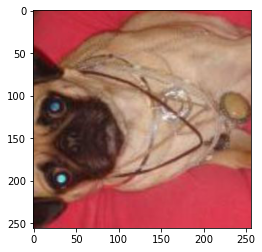

In [4]:
train_b1_img, train_b1_label = next(iter(train_240_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model (6 conv layers)

In [5]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.4),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)

learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_240_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_240_part = DataLoader(train_240,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_240_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.4, inplace=False)
    (1): Conv2d(64, 128,

Current training loss:3.037376642227173
Current training accuracy:0.158203125
Current validation loss:3.0648510456085205
Current validation accuracy:0.1374916136264801
Epoch:10
Iteration:1400
Time taken for the last 50 iterations: 35.12888526916504
Current training loss:2.8897266387939453
Current training accuracy:0.19580078125
Current validation loss:2.9767069816589355
Current validation accuracy:0.19248826801776886
Epoch:10
Iteration:1450
Time taken for the last 50 iterations: 35.31800603866577
Current training loss:2.941791296005249
Current training accuracy:0.19921875
Current validation loss:2.9977662563323975
Current validation accuracy:0.1797451376914978
Epoch:10
Iteration:1500
Time taken for the last 50 iterations: 35.211252212524414
Current training loss:2.9988765716552734
Current training accuracy:0.1806640625
Current validation loss:3.032979726791382
Current validation accuracy:0.1750503033399582
Epoch:11
Iteration:1550
Time taken for the last 50 iterations: 35.35621857643127

Current training loss:2.3258655071258545
Current training accuracy:0.36474609375
Current validation loss:2.55605149269104
Current validation accuracy:0.28906774520874023
Epoch:21
Iteration:3050
Time taken for the last 50 iterations: 35.648669719696045
Current training loss:2.263763904571533
Current training accuracy:0.384765625
Current validation loss:2.5156126022338867
Current validation accuracy:0.3112005293369293
Epoch:22
Iteration:3100
Time taken for the last 50 iterations: 35.28963327407837
Current training loss:2.2753374576568604
Current training accuracy:0.369140625
Current validation loss:2.4989724159240723
Current validation accuracy:0.3004694879055023
Epoch:22
Iteration:3150
Time taken for the last 50 iterations: 35.3003876209259
Current training loss:2.2507870197296143
Current training accuracy:0.37646484375
Current validation loss:2.500197649002075
Current validation accuracy:0.2977867126464844
Epoch:23
Iteration:3200
Time taken for the last 50 iterations: 35.10894656181335

Current training loss:1.8723806142807007
Current training accuracy:0.50341796875
Current validation loss:2.346571683883667
Current validation accuracy:0.3440643846988678
Epoch:33
Iteration:4700
Time taken for the last 50 iterations: 35.544921875
Current training loss:1.7454071044921875
Current training accuracy:0.5361328125
Current validation loss:2.314408302307129
Current validation accuracy:0.34607645869255066
Epoch:34
Iteration:4750
Time taken for the last 50 iterations: 35.34877562522888
Current training loss:1.7548370361328125
Current training accuracy:0.52490234375
Current validation loss:2.316113233566284
Current validation accuracy:0.3594902753829956
Epoch:34
Iteration:4800
Time taken for the last 50 iterations: 35.34605526924133
Current training loss:1.692602276802063
Current training accuracy:0.5673828125
Current validation loss:2.283362627029419
Current validation accuracy:0.3554661273956299
Epoch:34
Iteration:4850
Time taken for the last 50 iterations: 35.62558341026306
Cur

Epoch:45
Iteration:6300
Time taken for the last 50 iterations: 35.140565395355225
Current training loss:1.4678783416748047
Current training accuracy:0.61474609375
Current validation loss:2.227062463760376
Current validation accuracy:0.3749161660671234
Epoch:45
Iteration:6350
Time taken for the last 50 iterations: 35.56813955307007
Current training loss:1.4982578754425049
Current training accuracy:0.63427734375
Current validation loss:2.2717702388763428
Current validation accuracy:0.3608316481113434
Epoch:46
Iteration:6400
Time taken for the last 50 iterations: 35.31586718559265
Current training loss:1.4517402648925781
Current training accuracy:0.6513671875
Current validation loss:2.2475576400756836
Current validation accuracy:0.36217305064201355
Epoch:46
Iteration:6450
Time taken for the last 50 iterations: 35.319730043411255
Current training loss:1.469355821609497
Current training accuracy:0.62353515625
Current validation loss:2.2655556201934814
Current validation accuracy:0.354124754

Epoch:57
Iteration:7950
Time taken for the last 50 iterations: 35.160033226013184
Current training loss:1.1841347217559814
Current training accuracy:0.7314453125
Current validation loss:2.204172372817993
Current validation accuracy:0.3755868673324585
Epoch:57
Iteration:8000
Time taken for the last 50 iterations: 35.54278564453125
Current training loss:1.0652883052825928
Current training accuracy:0.759765625
Current validation loss:2.1729929447174072
Current validation accuracy:0.38967135548591614
Epoch:57
Iteration:8050
Time taken for the last 50 iterations: 35.07550024986267
Current training loss:1.1206302642822266
Current training accuracy:0.7529296875
Current validation loss:2.172748327255249
Current validation accuracy:0.391683429479599
Epoch:58
Iteration:8100
Time taken for the last 50 iterations: 35.30096197128296
Current training loss:1.0865525007247925
Current training accuracy:0.751953125
Current validation loss:2.1610398292541504
Current validation accuracy:0.3990610241889953

Epoch:69
Iteration:9600
Time taken for the last 50 iterations: 35.348538875579834
Current training loss:0.9182567596435547
Current training accuracy:0.81884765625
Current validation loss:2.1271677017211914
Current validation accuracy:0.4071093201637268
Epoch:69
Iteration:9650
Time taken for the last 50 iterations: 35.27690124511719
Current training loss:0.9500786662101746
Current training accuracy:0.8056640625
Current validation loss:2.1558351516723633
Current validation accuracy:0.3863179087638855
Epoch:69
Iteration:9700
Time taken for the last 50 iterations: 35.522183895111084
Current training loss:0.9454714059829712
Current training accuracy:0.81640625
Current validation loss:2.1534407138824463
Current validation accuracy:0.4077800214290619
Epoch:70
Iteration:9750
Time taken for the last 50 iterations: 35.02661609649658
Current training loss:0.9257375001907349
Current training accuracy:0.8212890625
Current validation loss:2.142937183380127
Current validation accuracy:0.3970489501953

Current validation loss:2.1234025955200195
Current validation accuracy:0.40576794743537903
Epoch:80
Iteration:11250
Time taken for the last 50 iterations: 35.07171583175659
Current training loss:0.7687256336212158
Current training accuracy:0.87451171875
Current validation loss:2.1154134273529053
Current validation accuracy:0.39973172545433044
Epoch:81
Iteration:11300
Time taken for the last 50 iterations: 34.88862681388855
Current training loss:0.7520668506622314
Current training accuracy:0.8671875
Current validation loss:2.1634297370910645
Current validation accuracy:0.3876592814922333
Epoch:81
Iteration:11350
Time taken for the last 50 iterations: 35.09695649147034
Current training loss:0.765775740146637
Current training accuracy:0.869140625
Current validation loss:2.121370553970337
Current validation accuracy:0.3957075774669647
Epoch:82
Iteration:11400
Time taken for the last 50 iterations: 35.021464586257935
Current training loss:0.7790388464927673
Current training accuracy:0.86132

Current training loss:0.7118894457817078
Current training accuracy:0.876953125
Current validation loss:2.1877167224884033
Current validation accuracy:0.3869886100292206
Epoch:92
Iteration:12900
Time taken for the last 50 iterations: 35.60916757583618
Current training loss:0.7025307416915894
Current training accuracy:0.888671875
Current validation loss:2.1605093479156494
Current validation accuracy:0.39973172545433044
Epoch:93
Iteration:12950
Time taken for the last 50 iterations: 35.27237582206726
Current training loss:0.6901979446411133
Current training accuracy:0.89794921875
Current validation loss:2.1566553115844727
Current validation accuracy:0.38900068402290344
Epoch:93
Iteration:13000
Time taken for the last 50 iterations: 35.44498658180237
Current training loss:0.651030421257019
Current training accuracy:0.91357421875
Current validation loss:2.160170555114746
Current validation accuracy:0.4004024267196655
Epoch:93
Iteration:13050
Time taken for the last 50 iterations: 35.2281553

Epoch:104
Iteration:14500
Time taken for the last 50 iterations: 34.83316969871521
Current training loss:0.5820367336273193
Current training accuracy:0.9169921875
Current validation loss:2.1567676067352295
Current validation accuracy:0.3863179087638855
Epoch:104
Iteration:14550
Time taken for the last 50 iterations: 35.27448582649231
Current training loss:0.5382745862007141
Current training accuracy:0.92578125
Current validation loss:2.133985757827759
Current validation accuracy:0.3957075774669647
Epoch:105
Iteration:14600
Time taken for the last 50 iterations: 35.16234564781189
Current training loss:0.5888350605964661
Current training accuracy:0.9130859375
Current validation loss:2.141810417175293
Current validation accuracy:0.40375587344169617
Epoch:105
Iteration:14650
Time taken for the last 50 iterations: 35.07950019836426
Current training loss:0.6648363471031189
Current training accuracy:0.90087890625
Current validation loss:2.2106311321258545
Current validation accuracy:0.3923541

Current training loss:0.48236873745918274
Current training accuracy:0.94287109375
Current validation loss:2.1253058910369873
Current validation accuracy:0.4084506928920746
Epoch:116
Iteration:16150
Time taken for the last 50 iterations: 35.1623432636261
Current training loss:0.48578327894210815
Current training accuracy:0.94189453125
Current validation loss:2.139714002609253
Current validation accuracy:0.41113346815109253
Epoch:116
Iteration:16200
Time taken for the last 50 iterations: 35.316683530807495
Current training loss:0.5452488660812378
Current training accuracy:0.9296875
Current validation loss:2.1477603912353516
Current validation accuracy:0.4077800214290619
Epoch:116
Iteration:16250
Time taken for the last 50 iterations: 35.25641989707947
Current training loss:0.5330649614334106
Current training accuracy:0.94287109375
Current validation loss:2.140774726867676
Current validation accuracy:0.4138162434101105
Epoch:117
Iteration:16300
Time taken for the last 50 iterations: 35.03

Epoch:127
Iteration:17750
Time taken for the last 50 iterations: 34.93706679344177
Current training loss:0.4208444058895111
Current training accuracy:0.9580078125
Current validation loss:2.1123383045196533
Current validation accuracy:0.4171696901321411
Epoch:128
Iteration:17800
Time taken for the last 50 iterations: 35.175466775894165
Current training loss:0.433024138212204
Current training accuracy:0.9453125
Current validation loss:2.161479949951172
Current validation accuracy:0.38900068402290344
Epoch:128
Iteration:17850
Time taken for the last 50 iterations: 35.44005036354065
Current training loss:0.4886643886566162
Current training accuracy:0.939453125
Current validation loss:2.2030370235443115
Current validation accuracy:0.38832998275756836
Epoch:128
Iteration:17900
Time taken for the last 50 iterations: 35.524226665496826
Current training loss:0.42725303769111633
Current training accuracy:0.95947265625
Current validation loss:2.1375856399536133
Current validation accuracy:0.40107

Current validation loss:2.16243577003479
Current validation accuracy:0.4077800214290619
Epoch:139
Iteration:19400
Time taken for the last 50 iterations: 35.549519300460815
Current training loss:0.38395583629608154
Current training accuracy:0.9599609375
Current validation loss:2.172973394393921
Current validation accuracy:0.40442654490470886
Epoch:139
Iteration:19450
Time taken for the last 50 iterations: 35.50578331947327
Current training loss:0.3534809648990631
Current training accuracy:0.9677734375
Current validation loss:2.140770196914673
Current validation accuracy:0.41448691487312317
Epoch:140
Iteration:19500
Time taken for the last 50 iterations: 35.39657807350159
Current training loss:0.37830615043640137
Current training accuracy:0.95849609375
Current validation loss:2.1612067222595215
Current validation accuracy:0.41046276688575745
Epoch:140
Iteration:19550
Time taken for the last 50 iterations: 35.375436782836914
Current training loss:0.3815860450267792
Current training accura

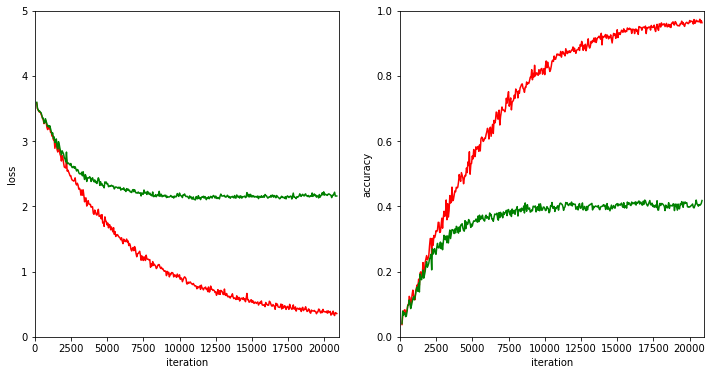

In [6]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,21000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,21000)
acc_graph.set_ylim(0,1)

plt.show()               


# Model (same as above, weaker regularization, slower learning)

In [7]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)

learning_rate = 0.0005
decay_rate = 0.00005
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 250

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_240_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_240_part = DataLoader(train_240,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_240_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(64, 128,

Current training loss:2.557140350341797
Current training accuracy:0.30615234375
Current validation loss:2.7604925632476807
Current validation accuracy:0.24681422114372253
Epoch:10
Iteration:1400
Time taken for the last 50 iterations: 35.38292384147644
Current training loss:2.4315383434295654
Current training accuracy:0.32470703125
Current validation loss:2.6420421600341797
Current validation accuracy:0.26224011182785034
Epoch:10
Iteration:1450
Time taken for the last 50 iterations: 35.56692409515381
Current training loss:2.4679079055786133
Current training accuracy:0.30126953125
Current validation loss:2.6377034187316895
Current validation accuracy:0.2803487479686737
Epoch:10
Iteration:1500
Time taken for the last 50 iterations: 35.54276514053345
Current training loss:2.339513063430786
Current training accuracy:0.34765625
Current validation loss:2.5894229412078857
Current validation accuracy:0.28370222449302673
Epoch:11
Iteration:1550
Time taken for the last 50 iterations: 35.463460206

Epoch:21
Iteration:3000
Time taken for the last 50 iterations: 35.55440950393677
Current training loss:1.228143572807312
Current training accuracy:0.708984375
Current validation loss:2.2817628383636475
Current validation accuracy:0.3715627193450928
Epoch:21
Iteration:3050
Time taken for the last 50 iterations: 35.50942087173462
Current training loss:1.2432056665420532
Current training accuracy:0.67822265625
Current validation loss:2.36091685295105
Current validation accuracy:0.3454057574272156
Epoch:22
Iteration:3100
Time taken for the last 50 iterations: 35.369686126708984
Current training loss:1.2479079961776733
Current training accuracy:0.6806640625
Current validation loss:2.3043372631073
Current validation accuracy:0.35680750012397766
Epoch:22
Iteration:3150
Time taken for the last 50 iterations: 35.40384483337402
Current training loss:1.2045968770980835
Current training accuracy:0.68310546875
Current validation loss:2.3611888885498047
Current validation accuracy:0.3407109379768371

Current validation loss:2.233909845352173
Current validation accuracy:0.38900068402290344
Epoch:33
Iteration:4650
Time taken for the last 50 iterations: 35.284188747406006
Current training loss:0.5216455459594727
Current training accuracy:0.89697265625
Current validation loss:2.3325703144073486
Current validation accuracy:0.3762575387954712
Epoch:33
Iteration:4700
Time taken for the last 50 iterations: 34.97462439537048
Current training loss:0.48175275325775146
Current training accuracy:0.91796875
Current validation loss:2.262561798095703
Current validation accuracy:0.3802816867828369
Epoch:34
Iteration:4750
Time taken for the last 50 iterations: 34.45324206352234
Current training loss:0.4896627962589264
Current training accuracy:0.9228515625
Current validation loss:2.302762985229492
Current validation accuracy:0.37223339080810547
Epoch:34
Iteration:4800
Time taken for the last 50 iterations: 35.00465202331543
Current training loss:0.47241905331611633
Current training accuracy:0.921386

Current training loss:0.2114829421043396
Current training accuracy:0.9765625
Current validation loss:2.3939123153686523
Current validation accuracy:0.38296446204185486
Epoch:45
Iteration:6300
Time taken for the last 50 iterations: 30.886096477508545
Current training loss:0.25850170850753784
Current training accuracy:0.96630859375
Current validation loss:2.4461452960968018
Current validation accuracy:0.3869886100292206
Epoch:45
Iteration:6350
Time taken for the last 50 iterations: 31.40951180458069
Current training loss:0.20473933219909668
Current training accuracy:0.970703125
Current validation loss:2.4102537631988525
Current validation accuracy:0.3849765360355377
Epoch:46
Iteration:6400
Time taken for the last 50 iterations: 30.868255615234375
Current training loss:0.18491017818450928
Current training accuracy:0.9765625
Current validation loss:2.432349443435669
Current validation accuracy:0.3869886100292206
Epoch:46
Iteration:6450
Time taken for the last 50 iterations: 31.053891658782

Epoch:56
Iteration:7900
Time taken for the last 50 iterations: 31.013133764266968
Current training loss:0.1105753555893898
Current training accuracy:0.98876953125
Current validation loss:2.5338127613067627
Current validation accuracy:0.3849765360355377
Epoch:57
Iteration:7950
Time taken for the last 50 iterations: 30.892436265945435
Current training loss:0.10043217986822128
Current training accuracy:0.99169921875
Current validation loss:2.4627764225006104
Current validation accuracy:0.3903420567512512
Epoch:57
Iteration:8000
Time taken for the last 50 iterations: 30.961005449295044
Current training loss:0.1186630055308342
Current training accuracy:0.9892578125
Current validation loss:2.5270345211029053
Current validation accuracy:0.3715627193450928
Epoch:57
Iteration:8050
Time taken for the last 50 iterations: 30.9159517288208
Current training loss:0.08360957354307175
Current training accuracy:0.9970703125
Current validation loss:2.502293109893799
Current validation accuracy:0.38631790

Current validation loss:2.6265172958374023
Current validation accuracy:0.3749161660671234
Epoch:68
Iteration:9550
Time taken for the last 50 iterations: 31.0000262260437
Current training loss:0.06495024263858795
Current training accuracy:0.994140625
Current validation loss:2.563283920288086
Current validation accuracy:0.37759894132614136
Epoch:69
Iteration:9600
Time taken for the last 50 iterations: 30.84548306465149
Current training loss:0.05291023850440979
Current training accuracy:0.99609375
Current validation loss:2.5983121395111084
Current validation accuracy:0.38363513350486755
Epoch:69
Iteration:9650
Time taken for the last 50 iterations: 30.91445541381836
Current training loss:0.06917836517095566
Current training accuracy:0.99072265625
Current validation loss:2.5885913372039795
Current validation accuracy:0.380952388048172
Epoch:69
Iteration:9700
Time taken for the last 50 iterations: 31.007662057876587
Current training loss:0.05792869254946709
Current training accuracy:0.99511

Current training loss:0.05137278139591217
Current training accuracy:0.994140625
Current validation loss:2.737391710281372
Current validation accuracy:0.37961098551750183
Epoch:80
Iteration:11200
Time taken for the last 50 iterations: 31.22904348373413
Current training loss:0.03938521817326546
Current training accuracy:0.99853515625
Current validation loss:2.6980397701263428
Current validation accuracy:0.3802816867828369
Epoch:80
Iteration:11250
Time taken for the last 50 iterations: 31.060515880584717
Current training loss:0.04406960308551788
Current training accuracy:0.99462890625
Current validation loss:2.721330165863037
Current validation accuracy:0.37290409207344055
Epoch:81
Iteration:11300
Time taken for the last 50 iterations: 30.967711925506592
Current training loss:0.04344271495938301
Current training accuracy:0.99560546875
Current validation loss:2.6814045906066895
Current validation accuracy:0.3910127580165863
Epoch:81
Iteration:11350
Time taken for the last 50 iterations: 30

Current validation loss:2.9141526222229004
Current validation accuracy:0.35680750012397766
Epoch:92
Iteration:12800
Time taken for the last 50 iterations: 31.158960580825806
Current training loss:0.028884613886475563
Current training accuracy:0.99951171875
Current validation loss:2.8523664474487305
Current validation accuracy:0.37826961278915405
Epoch:92
Iteration:12850
Time taken for the last 50 iterations: 30.883391618728638
Current training loss:0.023963449522852898
Current training accuracy:0.99853515625
Current validation loss:2.877992630004883
Current validation accuracy:0.37894031405448914
Epoch:92
Iteration:12900
Time taken for the last 50 iterations: 31.061124801635742
Current training loss:0.024793993681669235
Current training accuracy:0.9990234375
Current validation loss:2.8438522815704346
Current validation accuracy:0.3802816867828369
Epoch:93
Iteration:12950
Time taken for the last 50 iterations: 30.885741472244263
Current training loss:0.022315895184874535
Current trainin

Epoch:103
Iteration:14400
Time taken for the last 50 iterations: 31.049185752868652
Current training loss:0.016666395589709282
Current training accuracy:0.99951171875
Current validation loss:2.8955445289611816
Current validation accuracy:0.380952388048172
Epoch:103
Iteration:14450
Time taken for the last 50 iterations: 31.242829084396362
Current training loss:0.017680691555142403
Current training accuracy:0.99951171875
Current validation loss:2.8612282276153564
Current validation accuracy:0.39973172545433044
Epoch:104
Iteration:14500
Time taken for the last 50 iterations: 30.819626808166504
Current training loss:0.021986983716487885
Current training accuracy:0.99853515625
Current validation loss:2.943575859069824
Current validation accuracy:0.380952388048172
Epoch:104
Iteration:14550
Time taken for the last 50 iterations: 31.00725769996643
Current training loss:0.020567042753100395
Current training accuracy:0.99951171875
Current validation loss:2.9163661003112793
Current validation acc

Current training loss:0.01585455983877182
Current training accuracy:0.99951171875
Current validation loss:2.883814573287964
Current validation accuracy:0.3816230595111847
Epoch:115
Iteration:16050
Time taken for the last 50 iterations: 31.014134407043457
Current training loss:0.014865055680274963
Current training accuracy:0.99951171875
Current validation loss:2.9132394790649414
Current validation accuracy:0.3957075774669647
Epoch:115
Iteration:16100
Time taken for the last 50 iterations: 30.936920166015625
Current training loss:0.01584099978208542
Current training accuracy:0.9990234375
Current validation loss:2.8904526233673096
Current validation accuracy:0.3816230595111847
Epoch:116
Iteration:16150
Time taken for the last 50 iterations: 30.85878038406372
Current training loss:0.015629354864358902
Current training accuracy:0.9990234375
Current validation loss:2.8283066749572754
Current validation accuracy:0.39503687620162964
Epoch:116
Iteration:16200
Time taken for the last 50 iteratio

Current validation loss:2.9437294006347656
Current validation accuracy:0.3863179087638855
Epoch:126
Iteration:17650
Time taken for the last 50 iterations: 31.039079189300537
Current training loss:0.012685418128967285
Current training accuracy:0.99951171875
Current validation loss:3.0635876655578613
Current validation accuracy:0.36351442337036133
Epoch:127
Iteration:17700
Time taken for the last 50 iterations: 31.19388747215271
Current training loss:0.01703108660876751
Current training accuracy:0.99951171875
Current validation loss:2.967949628829956
Current validation accuracy:0.3816230595111847
Epoch:127
Iteration:17750
Time taken for the last 50 iterations: 31.006741523742676
Current training loss:0.011932953260838985
Current training accuracy:0.99853515625
Current validation loss:2.9583234786987305
Current validation accuracy:0.391683429479599
Epoch:128
Iteration:17800
Time taken for the last 50 iterations: 30.850547790527344
Current training loss:0.016639864072203636
Current trainin

Current training loss:0.010178112424910069
Current training accuracy:1.0
Current validation loss:2.989546537399292
Current validation accuracy:0.36753857135772705
Epoch:138
Iteration:19300
Time taken for the last 50 iterations: 31.03026795387268
Current training loss:0.008933044038712978
Current training accuracy:1.0
Current validation loss:2.940534830093384
Current validation accuracy:0.3856472074985504
Epoch:139
Iteration:19350
Time taken for the last 50 iterations: 30.99927592277527
Current training loss:0.015615294687449932
Current training accuracy:0.9990234375
Current validation loss:2.9826807975769043
Current validation accuracy:0.3762575387954712
Epoch:139
Iteration:19400
Time taken for the last 50 iterations: 31.049238920211792
Current training loss:0.013187337666749954
Current training accuracy:1.0
Current validation loss:3.1156721115112305
Current validation accuracy:0.3715627193450928
Epoch:139
Iteration:19450
Time taken for the last 50 iterations: 30.90578007698059
Current

Epoch:150
Iteration:20900
Time taken for the last 50 iterations: 30.878498077392578
Current training loss:0.011386766098439693
Current training accuracy:1.0
Current validation loss:2.893516778945923
Current validation accuracy:0.3769282400608063
Epoch:150
Iteration:20950
Time taken for the last 50 iterations: 30.935356616973877
Current training loss:0.00786047987639904
Current training accuracy:1.0
Current validation loss:2.992962121963501
Current validation accuracy:0.3762575387954712
Epoch:151
Iteration:21000
Time taken for the last 50 iterations: 30.84896230697632
Current training loss:0.008095402270555496
Current training accuracy:1.0
Current validation loss:3.013073205947876
Current validation accuracy:0.380952388048172
Epoch:151
Iteration:21050
Time taken for the last 50 iterations: 30.92679238319397
Current training loss:0.008770031854510307
Current training accuracy:1.0
Current validation loss:3.0205001831054688
Current validation accuracy:0.38430583477020264
Epoch:151
Iteratio

Epoch:162
Iteration:22550
Time taken for the last 50 iterations: 30.857282638549805
Current training loss:0.007890498265624046
Current training accuracy:1.0
Current validation loss:2.955592393875122
Current validation accuracy:0.3762575387954712
Epoch:162
Iteration:22600
Time taken for the last 50 iterations: 30.98539423942566
Current training loss:0.007757263258099556
Current training accuracy:1.0
Current validation loss:3.027346611022949
Current validation accuracy:0.37223339080810547
Epoch:162
Iteration:22650
Time taken for the last 50 iterations: 30.93606400489807
Current training loss:0.008474942296743393
Current training accuracy:0.99951171875
Current validation loss:2.9945273399353027
Current validation accuracy:0.37826961278915405
Epoch:163
Iteration:22700
Time taken for the last 50 iterations: 30.654320240020752
Current training loss:0.00818875152617693
Current training accuracy:0.99951171875
Current validation loss:2.9593417644500732
Current validation accuracy:0.366867870092

Epoch:174
Iteration:24200
Time taken for the last 50 iterations: 30.866092443466187
Current training loss:0.006938170175999403
Current training accuracy:0.99951171875
Current validation loss:2.9611692428588867
Current validation accuracy:0.3762575387954712
Epoch:174
Iteration:24250
Time taken for the last 50 iterations: 30.96205472946167
Current training loss:0.013262366876006126
Current training accuracy:1.0
Current validation loss:3.079179525375366
Current validation accuracy:0.3749161660671234
Epoch:174
Iteration:24300
Time taken for the last 50 iterations: 30.999120235443115
Current training loss:0.00984661839902401
Current training accuracy:1.0
Current validation loss:2.9974119663238525
Current validation accuracy:0.38363513350486755
Epoch:175
Iteration:24350
Time taken for the last 50 iterations: 30.93392777442932
Current training loss:0.010729769244790077
Current training accuracy:1.0
Current validation loss:3.0091142654418945
Current validation accuracy:0.37357479333877563
Epoc

Epoch:185
Iteration:25850
Time taken for the last 50 iterations: 30.95939040184021
Current training loss:0.007778835482895374
Current training accuracy:1.0
Current validation loss:2.9903502464294434
Current validation accuracy:0.3856472074985504
Epoch:186
Iteration:25900
Time taken for the last 50 iterations: 30.837773084640503
Current training loss:0.009926078841090202
Current training accuracy:0.99951171875
Current validation loss:3.068387985229492
Current validation accuracy:0.380952388048172
Epoch:186
Iteration:25950
Time taken for the last 50 iterations: 30.998194932937622
Current training loss:0.00841007474809885
Current training accuracy:0.9990234375
Current validation loss:3.077244997024536
Current validation accuracy:0.38967135548591614
Epoch:187
Iteration:26000
Time taken for the last 50 iterations: 30.839953660964966
Current training loss:0.006398341618478298
Current training accuracy:1.0
Current validation loss:3.0659830570220947
Current validation accuracy:0.38832998275756

KeyboardInterrupt: 

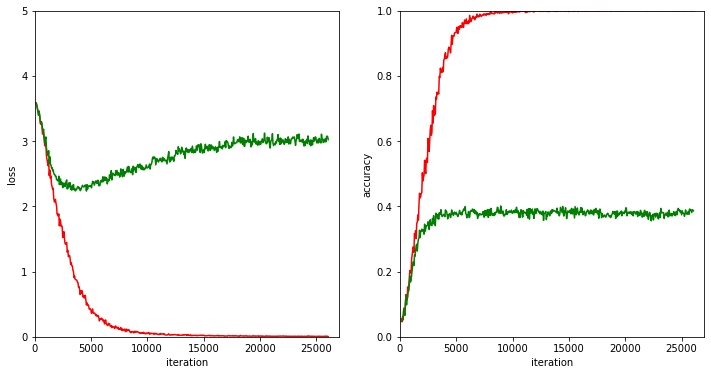

In [8]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,27000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,27000)
acc_graph.set_ylim(0,1)

plt.show()               


# Model (6 conv layers, 2 dense layers)

In [9]:
class PetCNN6ch(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.4),
                                    nn.Linear(1024, 370))
        
        self.dense2 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Linear(370, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)     
        out = self.dense1(out)
        out = self.dense2(out)
        out = nn.functional.log_softmax(out,dim=1)    
        
        return out
    


model1 = PetCNN6ch()
loss_function = nn.NLLLoss()


print(model1)
        


learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_240_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_240_part = DataLoader(train_240,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_240_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


PetCNN6ch(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(64, 25

Epoch:9
Iteration:1350
Time taken for the last 50 iterations: 52.27576422691345
Current training loss:2.6015095710754395
Current training accuracy:0.2529296875
Current validation loss:2.7238857746124268
Current validation accuracy:0.24480214715003967
Epoch:10
Iteration:1400
Time taken for the last 50 iterations: 55.63247513771057
Current training loss:2.5433502197265625
Current training accuracy:0.2841796875
Current validation loss:2.731806516647339
Current validation accuracy:0.24614353477954865
Epoch:10
Iteration:1450
Time taken for the last 50 iterations: 53.63935351371765
Current training loss:2.485250949859619
Current training accuracy:0.28564453125
Current validation loss:2.676232099533081
Current validation accuracy:0.2528504431247711
Epoch:10
Iteration:1500
Time taken for the last 50 iterations: 52.6644127368927
Current training loss:2.386932849884033
Current training accuracy:0.3349609375
Current validation loss:2.610597610473633
Current validation accuracy:0.2790073752403259


Epoch:21
Iteration:3000
Time taken for the last 50 iterations: 51.197654724121094
Current training loss:1.1511235237121582
Current training accuracy:0.68896484375
Current validation loss:2.3680577278137207
Current validation accuracy:0.34607645869255066
Epoch:21
Iteration:3050
Time taken for the last 50 iterations: 51.31617784500122
Current training loss:1.3149950504302979
Current training accuracy:0.6455078125
Current validation loss:2.34523606300354
Current validation accuracy:0.35747820138931274
Epoch:22
Iteration:3100
Time taken for the last 50 iterations: 51.12016987800598
Current training loss:1.1135059595108032
Current training accuracy:0.70751953125
Current validation loss:2.33083176612854
Current validation accuracy:0.34741783142089844
Epoch:22
Iteration:3150
Time taken for the last 50 iterations: 51.192805767059326
Current training loss:1.0844746828079224
Current training accuracy:0.69921875
Current validation loss:2.400552988052368
Current validation accuracy:0.3594902753829

Current validation loss:2.392335891723633
Current validation accuracy:0.38430583477020264
Epoch:33
Iteration:4650
Time taken for the last 50 iterations: 51.0639910697937
Current training loss:0.3081730306148529
Current training accuracy:0.95068359375
Current validation loss:2.4355461597442627
Current validation accuracy:0.3802816867828369
Epoch:33
Iteration:4700
Time taken for the last 50 iterations: 51.09046196937561
Current training loss:0.3717517554759979
Current training accuracy:0.935546875
Current validation loss:2.3953604698181152
Current validation accuracy:0.38296446204185486
Epoch:34
Iteration:4750
Time taken for the last 50 iterations: 51.01212763786316
Current training loss:0.38271355628967285
Current training accuracy:0.9248046875
Current validation loss:2.447604179382324
Current validation accuracy:0.37223339080810547
Epoch:34
Iteration:4800
Time taken for the last 50 iterations: 51.11208462715149
Current training loss:0.36717188358306885
Current training accuracy:0.92968

Current training loss:0.17562122642993927
Current training accuracy:0.97412109375
Current validation loss:2.7323639392852783
Current validation accuracy:0.35077130794525146
Epoch:45
Iteration:6300
Time taken for the last 50 iterations: 51.37243390083313
Current training loss:0.1552998274564743
Current training accuracy:0.97900390625
Current validation loss:2.552351474761963
Current validation accuracy:0.3822937607765198
Epoch:45
Iteration:6350
Time taken for the last 50 iterations: 51.54863381385803
Current training loss:0.1903294324874878
Current training accuracy:0.97314453125
Current validation loss:2.5788261890411377
Current validation accuracy:0.3695506453514099
Epoch:46
Iteration:6400
Time taken for the last 50 iterations: 51.26925802230835
Current training loss:0.13867135345935822
Current training accuracy:0.98193359375
Current validation loss:2.586007833480835
Current validation accuracy:0.3816230595111847
Epoch:46
Iteration:6450
Time taken for the last 50 iterations: 51.420702

Epoch:56
Iteration:7900
Time taken for the last 50 iterations: 51.22303557395935
Current training loss:0.08361483365297318
Current training accuracy:0.99462890625
Current validation loss:2.6260199546813965
Current validation accuracy:0.3715627193450928
Epoch:57
Iteration:7950
Time taken for the last 50 iterations: 50.96616983413696
Current training loss:0.08763715624809265
Current training accuracy:0.99267578125
Current validation loss:2.704615592956543
Current validation accuracy:0.3802816867828369
Epoch:57
Iteration:8000
Time taken for the last 50 iterations: 51.277862787246704
Current training loss:0.08099652081727982
Current training accuracy:0.9931640625
Current validation loss:2.6919167041778564
Current validation accuracy:0.38430583477020264
Epoch:57
Iteration:8050
Time taken for the last 50 iterations: 51.052956342697144
Current training loss:0.06976757943630219
Current training accuracy:0.99462890625
Current validation loss:2.6440324783325195
Current validation accuracy:0.3863

Current validation loss:2.778515100479126
Current validation accuracy:0.3802816867828369
Epoch:68
Iteration:9550
Time taken for the last 50 iterations: 51.05903434753418
Current training loss:0.03665430471301079
Current training accuracy:0.9990234375
Current validation loss:2.7222952842712402
Current validation accuracy:0.3910127580165863
Epoch:69
Iteration:9600
Time taken for the last 50 iterations: 51.03669619560242
Current training loss:0.05824846029281616
Current training accuracy:0.994140625
Current validation loss:2.7413275241851807
Current validation accuracy:0.3903420567512512
Epoch:69
Iteration:9650
Time taken for the last 50 iterations: 53.8276789188385


KeyboardInterrupt: 

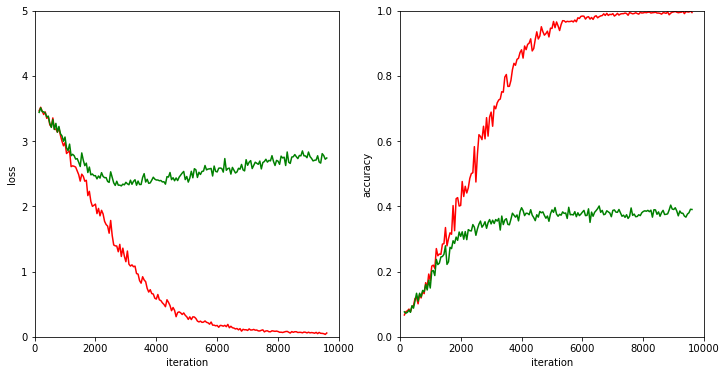

In [10]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,10000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,10000)
acc_graph.set_ylim(0,1)

plt.show()               
